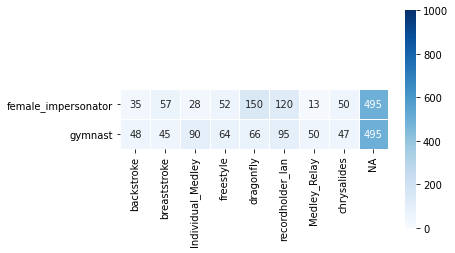

In [2]:
# %load analysis
from data_load import *
from common import identity_morphism
from graph_show import *
from my_function import *
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pygraphviz as pyg
import pprint
import math
from scipy.stats import pearsonr,spearmanr

# 連想強度をヒートマップで表示・出力する関数
#def adj_matrix(w2v_seed,source, target):
def adj_matrix(target,source):    

    #全てのイメージのデータを取得する
    node_data = get_node_data()
    
    assoc_net = make_assoc_net(source = "source", target = "target")



    A_node_data = sort_cossim_cod_data(target)
    B_node_data = sort_cossim_cod_data(source)

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data:
            if assoc_net.has_edge(B_node,A_node):
                weight = assoc_net[B_node][A_node]["weight"]
            else:
                weight = 0.0
            row.append(weight)
        matrix.append(row)

    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data)
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1.0,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True)
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.savefig("./heatmap/nt_weight_"+target+"_"+source+".pdf",bbox_inches="tight")
    
def adj_matrix_in_coslice(center):

    #全てのイメージのデータを取得する
    node_data = get_node_data()  
    
    assoc_net = make_assoc_net(source = "source", target = "target")

    center_node_data = sort_cossim_cod_data(center)

    matrix = list()
    for node1 in center_node_data:
        row = list()
        for node2 in center_node_data:
            if assoc_net.has_edge(node1,node2):
                weight = assoc_net[node1][node2]["weight"]
            else:
                weight = 0.0
            row.append(weight)
        matrix.append(row)

    df = pd.DataFrame(matrix,index=center_node_data,columns=center_node_data)
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1.0,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True)
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.savefig("./heatmap/nt_weight_in_coslice_"+center+".png",bbox_inches="tight")
adj_matrix_in_coslice("butterfly")
adj_matrix_in_coslice("dancer")


# 記録した関手Fからどの対象がどの対象と対応づきやすいかをヒートマップで表示・出力する
#def object_TINT_edge_correspondence_heatmap(w2v_seed, source, target):
def object_TINT_edge_correspondence_heatmap(target,source):
    
    Corr_DIR = "./object_edge_correspondence/"


    #全てのイメージのデータを取得する
#    node_data = get_node_data(w2v_seed)
    node_data = get_node_data()
    weights = [0.05, 0.275, 0.5, 0.725, 0.95] # 0.05から0.225刻みの線形

    assoc_net = make_assoc_net(source="source",target="target")

    df_edge_corr = pd.read_csv(Corr_DIR+"Date_all_seed_6000_{}_{}_full_anti_1_iter_1000_correspondence.tsv".format(target,source),header=0,encoding="utf-8", sep="\t")
    df_edge_corr = df_edge_corr.fillna("NA")
    A_node_data = sort_cossim_cod_data(target)
    B_node_data = sort_cossim_cod_data(source)
    edge_corr_dict = {(B_node,A_node):0 for A_node in A_node_data for B_node in B_node_data}

    for B_node in B_node_data:
        corr_A_nodes = df_edge_corr[df_edge_corr["B_cod"]==B_node]
        for corr_A in corr_A_nodes.itertuples():
            count = corr_A.count
            edge_corr_dict[(B_node,corr_A.A_cod)] = count

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data+["NA"]:
            row.append(edge_corr_dict[(B_node,A_node)])
        matrix.append(row)

    
    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data+["NA"])
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1000,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True, fmt="d")
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    # plt.savefig("nt_weight_"+A_name+"_"+B_name+".pdf")
    plt.savefig("./heatmap/object_edge_correspondence_count_"+target+"_"+source+".pdf")
    # plt.savefig("word2vec_edge_corr_count_"+A_name+"_"+B_name+".png")
     
# 記録した関手Fからどの対象がどの対象と対応づきやすいかをヒートマップで表示・出力する
#def tri_TINT_edge_correspondence_heatmap(w2v_seed, source, target, tri_dom, tri_cod):
def tri_TINT_edge_correspondence_heatmap(target,source, tri_dom, tri_cod):
    Corr_DIR = "./tri_edge_correspondence/"

    #全てのイメージのデータを取得する
    node_data = get_node_data()

    is_fill_graph = False

    df_edge_corr = pd.read_csv(Corr_DIR+"FOREDGE_Date_all_seed_6000_{}_{}_{}_{}_forced_anti_1_iter_1000_correspondence.tsv".format(target,source,tri_dom,tri_cod),header=0,encoding="utf-8", sep="\t")

    df_edge_corr = df_edge_corr.fillna("NA")
    A_node_data = sort_cossim_cod_data(target)

    if is_fill_graph:
        B_node_data = sort_cossim_cod_data(source)
    else:
        B_node_data = [tri_dom,tri_cod] 


    edge_corr_dict = {(B_node,A_node):0 for A_node in A_node_data for B_node in B_node_data}
    for B_node in B_node_data:            
        corr_A_nodes = df_edge_corr[(df_edge_corr["B_cod"]==B_node) & (df_edge_corr["B_dom"] == source)]
        for corr_A in corr_A_nodes.itertuples():
            count = corr_A.count
            edge_corr_dict[(B_node,corr_A.A_cod)] = count

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data+["NA"]:
            if (B_node,A_node) in edge_corr_dict:
                count = edge_corr_dict[(B_node,A_node)]
            else:
                count = 0
            row.append(count)
        matrix.append(row)

    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data+["NA"])
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1000,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True,fmt="d",square=True)
    plt.ylim(0,len(B_node_data))
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.savefig("./heatmap/tri_edge_correspondence_count_{}_{}_{}_{}".format(target,source,tri_dom,tri_cod),bbox_inches="tight")

def human_correspondence_heatmap(target,source):
    human_corr_data = pd.read_csv("./human_correspondence/human_correspondence.csv",header=0,index_col=0)
    human_corr_data = human_corr_data.rename(columns={"舞う":"dance","飛ぶ":"fly","花":"flower","女性":"woman","空":"sky","美しさ":"beauty","儚さ":"empty",
                                "羽":"feather"},index={"踊り":"dance","女性":"woman","スカート":"skirt","夜":"night","音楽":"music","回る":"spin",
                                                      "揺れる":"shake","舞台":"stage"})
    plt.clf()
    sns.heatmap(human_corr_data,vmin=1.0,vmax=5.0,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True)
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.savefig("./heatmap/human_correspondence_{}_{}.pdf".format(target,source))


# TINTの対象同士のシミュレーション結果の対応づけを行列形式に整形する
def load_object_correspondence_data(fname,target,source):
    Corr_DIR = "./object_edge_correspondence/"

    #全てのイメージのデータを取得する
    node_data = get_node_data()
    df_edge_corr = pd.read_csv(Corr_DIR+fname,header=0,encoding="utf-8",sep="\t")

    df_edge_corr = df_edge_corr.fillna("NA")
    A_node_data = list(node_data[node_data[0]==target][1])
    B_node_data = list(node_data[node_data[0]==source][1])
    A_node_data.remove(target)
    B_node_data.remove(source)
    edge_corr_dict = {(B_node,A_node):0 for A_node in A_node_data for B_node in B_node_data}

    for B_node in B_node_data:
        corr_A_nodes = df_edge_corr[df_edge_corr["B_cod"]==B_node]
        for corr_A in corr_A_nodes.itertuples():
            count = corr_A.count
            edge_corr_dict[(B_node,corr_A.A_cod)] = count

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data+["NA"]:
            row.append(edge_corr_dict[(B_node,A_node)])
        matrix.append(row)

    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data+["NA"])
    return df

# 対象同士のTINTのシミュレーションの対応づけと、人間の対応づけの相関係数を計算し、ファイルに吐き出す
def human_object_data_correlation_to_csv(TINT_corr_fname,target,source,r_function=pearsonr):
    TINT_corr_data = load_object_correspondence_data(TINT_corr_fname,target,source)
    human_corr_data = pd.read_csv("./human_correspondence/human_correspondence.csv",header=0,index_col=0)
    human_corr_data = human_corr_data.rename(columns={"舞う":"dance","飛ぶ":"fly","花":"flower","女性":"woman","空":"sky","美しさ":"beauty","儚さ":"empty",
                                "羽":"feather"},index={"踊り":"dance","女性":"woman","スカート":"skirt","夜":"night","音楽":"music","回る":"spin",
                                                      "揺れる":"shake","舞台":"stage"})
    S_images = list(human_corr_data.index)
    save_dir = "./corref/"
    mtx = []
    for S_image in S_images:
        TINT_row = TINT_corr_data.loc[S_image]
        human_row = human_corr_data.loc[S_image]
        corref, p_value = r_function(list(human_row),list(TINT_row))#ピアソンの相関係数とp値
        mtx.append((S_image,corref,p_value))
    df = pd.DataFrame(mtx,columns=("S_image", "correlation","p_value"))
    df.to_csv(save_dir+"human_object_TINT_{}_correlation.tsv".format(r_function.__name__),sep="\t")  

# 全ての三角構造同士のシミュレーションの対応づけと、人間の対応づけの相関係数を計算し、ファイルに吐き出す
def human_tri_data_correlation_to_csv(target,source,seed,r_function=pearsonr):
    Corr_DIR = "./tri_edge_correspondence/"

    #全てのイメージのデータを取得する
    node_data = get_node_data()

    # 人間のデータを読み込み
    # TODO:ここで人間のデータhuman_corrspondence.csvを読み込む

    human_corr_data = pd.read_csv("./human_correspondence/human_correspondence.csv",header=0,index_col=0)
    human_corr_data = human_corr_data.rename(columns={"舞う":"dance","飛ぶ":"fly","花":"flower","女性":"woman","空":"sky","美しさ":"beauty","儚さ":"empty",
                                "羽":"feather"},index={"踊り":"dance","女性":"woman","スカート":"skirt","夜":"night","音楽":"music","回る":"spin",
                                                      "揺れる":"shake","舞台":"stage"})

    # 三角構造同士の対応づけを読み込み
    tri_corr_data = pd.read_csv(Corr_DIR+"seed_{}_{}_{}_all_triangle_correspondence.tsv".format(seed,target,source),header=0,index_col=0,encoding="utf-8",sep="\t")

    T_images = list(node_data[node_data[0]=="butterfly"][1])
    T_images.remove("butterfly")
    T_images.append("NA")
    S_images = list(node_data[node_data[0]=="dancer"][1])
    S_images.remove("dancer")

    tri_human_corrcef_list = []
    tri_human_corrcef_all_image_list = []
    tri_human_p_value_list = []
    for idx in range(0,len(tri_corr_data),2):
        first_image = T_images[0]
        TINT_row1 = np.array(tri_corr_data.loc[idx,first_image:],dtype=float)       #コスライス圏の射のdomの対応行
        TINT_row2 = np.array(tri_corr_data.loc[idx+1,first_image:],dtype=float)     #コスライス圏の射のcodの対応行
        tri_dom = tri_corr_data["dom/cod"][idx]  #コスライス圏のdom
        tri_cod = tri_corr_data["dom/cod"][idx+1]  #コスライス圏のcod

        human_row1 = np.array(human_corr_data.loc[tri_dom][:],dtype=float)
        human_row2 = np.array(human_corr_data.loc[tri_dom][:],dtype=float)
        if len(TINT_row1) != 9 or len(TINT_row2) != 9 or len(human_row1) != 9 or len(human_row2)!=9:
            print("data format error: row is 9 col")
        # 相関係数を計算するときにfloat関係でエラー出ることがあるその際はdtypeを明示的にfloatに変更すること
        # 三角構造を構成するイメージのTINTの対応づけとそのイメージの人間の対応づけの相関を計算
        dom_corref = 0
        cod_corref = 0
        dom_p = 0
        cod_p = 0
        corref_list1 = []
        corref_list2 = []
        p_value_list1 = []
        p_value_list2 = []
        for idx,human_row in human_corr_data.iterrows():
            row1_corr,r1_p = r_function(np.array(human_row,dtype=float),TINT_row1)
            row2_corr,r2_p = r_function(np.array(human_row,dtype=float),TINT_row2)

            if tri_dom == idx:
                dom_corref = row1_corr
                dom_p = r1_p
            if tri_cod == idx:
                cod_corref = row2_corr
                cod_p = r2_p

            corref_list1.append(row1_corr)
            corref_list2.append(row2_corr)
            p_value_list1.append(r1_p)
            p_value_list2.append(r2_p)

        tri_human_corrcef_list.append(
            [tri_dom, tri_cod, dom_corref, cod_corref, dom_p, cod_p]
        )
        tri_human_corrcef_all_image_list.append([(tri_dom,tri_cod),tri_dom] + corref_list1)
        tri_human_corrcef_all_image_list.append([(tri_dom,tri_cod),tri_cod] + corref_list2)
        tri_human_p_value_list.append([(tri_dom,tri_cod),tri_dom] + p_value_list1)
        tri_human_p_value_list.append([(tri_dom,tri_cod),tri_cod] + p_value_list2)

    # 同じ対象の対応づけの傾向の相関係数をファイルへ
    df = pd.DataFrame(tri_human_corrcef_list,columns=("dom","cod","dom_correlation","cod_correlation","dom_p","cod_p"))
    df.to_csv("./corref/human_tri_data_{}_correlation.tsv".format(r_function.__name__),sep="\t")

    # １つの対象の対応づけの傾向に対して人間の8つの対象の対応づけの傾向との相関係数をファイルへ
    df = pd.DataFrame(tri_human_corrcef_all_image_list,columns=(["tri_edge","dom/cod"] + S_images))
    df.to_csv("./corref/human_tri_data_{}_correlation_all_images.tsv".format(r_function.__name__),sep="\t")

    # １つの対象の対応づけの傾向に対して人間の8つの対象の対応づけの傾向との相関係数のp値をファイルへ
    df = pd.DataFrame(tri_human_p_value_list, columns=(["tri_edge","dom/cod"] + S_images))
    df.to_csv("./corref/human_tri_data_{}_p_value_all_images.tsv".format(r_function.__name__),sep="\t")


# 人間と三角構造同士のTINTの相関のうち閾値を超えているものを表示
def tri_correlation_analysis_over_th(r_function=spearmanr,corref_th = 0.4):
    # 人間の対応と、三角構造のTINTの対応づけとの相関データを取り出す
    tri_corref = pd.read_csv("./corref/human_tri_data_{}_correlation.tsv".format(r_function.__name__),header=0,index_col=0,sep="\t")
    tri_corref_over_th = tri_corref[(tri_corref["dom_correlation"] >= corref_th) & (tri_corref["cod_correlation"] >= corref_th)]
    tri_corref_over_th = tri_corref_over_th.assign(order = lambda df: df.dom_correlation + df.cod_correlation)
    tri_corref_over_th.sort_values("order",ascending=False)
    print("相関がどちらも{}以上の三角構造({}個)".format(corref_th,len(tri_corref_over_th)))
    print("(tri_dom,tri_cod) \t dom_r \t cod_r \t dom_p \t cod_p")
    for idx,row in tri_corref_over_th.iterrows():
        dom, cod = row["dom"], row["cod"]
        dom_corr = row["dom_correlation"]
        cod_corr = row["cod_correlation"]
        dom_p    = row["dom_p"]
        cod_p    = row["cod_p"]
        print("({:4} , {:4}) \t {} \t {} \t {} \t {}".format(dom,cod,round(dom_corr,2),round(cod_corr,2),round(dom_p,3),round(cod_p,3)))

# 人間と対象同士同士のTINTの相関のうち閾値を超えているものを表示
def object_correlation_analysis_over_th(r_function=pearsonr, corref_th = 0.4):
    # 人間の対応と、対象同士のTINTの対応づけとの相関データを取り出す
    object_corref = pd.read_csv("./corref/human_object_TINT_{}_correlation.tsv".format(r_function.__name__),header=0,index_col=0,sep="\t")
    object_corref_over_th = object_corref[object_corref["correlation"] >= corref_th]
 
    print("相関がどちらも{}以上の三角構造".format(corref_th))
    print("image \t r \t p_value")
    for idx,row in object_corref_over_th.iterrows():
        S_image = row["S_image"]
        corref  = row["correlation"]
        p_value = row["p_value"]
        print("{} \t {} \t {}".format(S_image,round(corref,2),round(p_value,3)))

def compare_tri_and_object_correlation(r_function=pearsonr):
    object_corref = pd.read_csv("./corref/human_object_TINT_{}_correlation.tsv".format(r_function.__name__),header=0,index_col=1,sep="\t")
    tri_corref = pd.read_csv("./corref/human_tri_data_{}_correlation.tsv".format(r_function.__name__),header=0,index_col=0,sep="\t")

    is_over_corref_matrix = []
    is_less_corref_matrix = []

    for idx,row in tri_corref.iterrows():
        dom, cod = row["dom"], row["cod"]
        dom_tri_corr = row["dom_correlation"]
        cod_tri_corr = row["cod_correlation"]
        dom_p    = row["dom_p"]
        cod_p    = row["cod_p"]
        dom_obj_corr = float(object_corref.loc[dom,["correlation"]])
        cod_obj_corr = float(object_corref.loc[cod,["correlation"]])
        if dom_tri_corr > dom_obj_corr and cod_tri_corr > cod_obj_corr:
            is_over_corref_matrix.append((dom,cod,round(dom_tri_corr,2),round(cod_tri_corr,2),round(dom_p,3),round(cod_p,3),dom_tri_corr+cod_tri_corr))
        elif dom_tri_corr < dom_obj_corr and cod_tri_corr < cod_obj_corr:
            is_less_corref_matrix.append((dom,cod,round(dom_tri_corr,2),round(cod_tri_corr,2),round(dom_p,3),round(cod_p,3),dom_tri_corr+cod_tri_corr))

    is_over_corref_matrix = sorted(is_over_corref_matrix,key= lambda x: x[-1],reverse=True)
    print("人間との相関が三角構造のdom,codどちらでも対象同士を超えている三角構造({}個)".format(len(is_over_corref_matrix)))
    print("(tri_dom,tri_cod) \t dom_r \t cod_r \t dom_p \t cod_p")
    for dom,cod,dom_corr,cod_corr,dom_p,cod_p,_ in is_over_corref_matrix:
        print("({:4} , {:4}) \t {} \t {} \t {} \t {}".format(dom,cod,dom_corr,cod_corr,dom_p,cod_p))

    is_less_corref_matrix = sorted(is_less_corref_matrix,key= lambda x: x[-1],reverse=True)
    print("人間との相関が三角構造のdom,codどちらでも対象同士を下回っている三角構造({}個)".format(len(is_less_corref_matrix)))
    print("(tri_dom,tri_cod) \t dom_r \t cod_r \t dom_p \t cod_p")
    for dom,cod,dom_corr,cod_corr,dom_p,cod_p,_ in is_less_corref_matrix:
        print("({:4} , {:4}) \t {} \t {} \t {} \t {}".format(dom,cod,dom_corr,cod_corr,dom_p,cod_p))

def over_less_tri_and_object_assoc_prob_th(r_function=pearsonr):
    object_corref = pd.read_csv("./corref/human_object_TINT_{}_correlation.tsv".format(r_function.__name__),header=0,index_col=1,sep="\t")
    tri_corref = pd.read_csv("./corref/human_tri_data_{}_correlation.tsv".format(r_function.__name__),header=0,index_col=0,sep="\t")
   

    assoc_data = load_three_metaphor_data()
    assoc_net = nx.from_pandas_edgelist(df = assoc_data, source='source', target='target',edge_attr=["weight"], create_using=nx.DiGraph)
    identity_morphism(assoc_net)


    is_over_corref_matrix = []
    is_less_corref_matrix = []

    for idx,row in tri_corref.iterrows():
        dom, cod = row["dom"], row["cod"]
        dom_tri_corr = row["dom_correlation"]
        cod_tri_corr = row["cod_correlation"]
        dom_p    = row["dom_p"]
        cod_p    = row["cod_p"]
        dom_obj_corr = float(object_corref.loc[dom,["correlation"]])
        cod_obj_corr = float(object_corref.loc[cod,["correlation"]])
        if dom_tri_corr > dom_obj_corr and cod_tri_corr > cod_obj_corr:
            if assoc_net[dom][cod]["weight"] >= 0.75:
                is_over_corref_matrix.append((dom,cod,assoc_net[dom][cod]["weight"]))
        elif dom_tri_corr < dom_obj_corr and cod_tri_corr < cod_obj_corr:
            if assoc_net[dom][cod]["weight"] >= 0.75:
                is_less_corref_matrix.append((dom,cod,assoc_net[dom][cod]["weight"]))

    is_over_corref_matrix = sorted(is_over_corref_matrix,key=lambda x: x[-1],reverse=True)
    print("人間との相関が三角構造のdom,codどちらでも対象同士を超えている三角構造で射の連想確率が0.75を超えているもの({}個)".format(len(is_over_corref_matrix)))
    print("(tri_dom,tri_cod) \t dom_r \t cod_r \t dom_p \t cod_p")
    for dom,cod,prob in is_over_corref_matrix:
        print("({:4} , {:4}) \t {} ".format(dom,cod,prob))

    is_less_corref_matrix = sorted(is_less_corref_matrix,key=lambda x: x[-1],reverse=True)
    print("人間との相関が三角構造のdom,codどちらでも対象同士を下回っている三角構造で射の連想確率が0.75を超えているもの({}個)".format(len(is_less_corref_matrix)))
    print("(tri_dom,tri_cod) \t dom_r \t cod_r \t dom_p \t cod_p")
    for dom,cod,prob in is_less_corref_matrix:
        print("({:4} , {:4}) \t {} ".format(dom,cod,prob))
    
if __name__ == "__main__":
    # 連想確率、TINTのシミュレーション結果(対象同士、三角構造同士)、人間の比喩解釈データをヒートマップで出力する

    adj_matrix("butterfly","dancer")
    adj_matrix_in_coslice("butterfly")
    adj_matrix_in_coslice("dancer")
    object_TINT_edge_correspondence_heatmap("butterfly","dancer")
    B_node_data = sort_cossim_cod_data("dancer")
    for dom,cod in iter.permutations(B_node_data,2):
        tri_TINT_edge_correspondence_heatmap("butterfly","dancer",dom,cod)

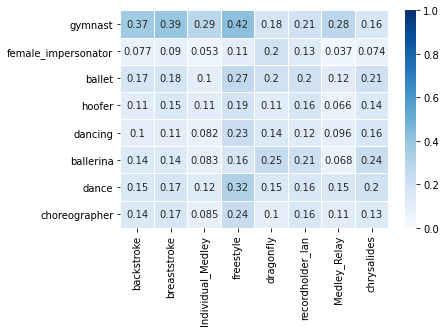

In [3]:
adj_matrix("butterfly","dancer")


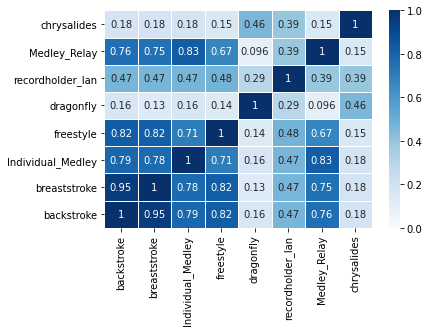

In [4]:
adj_matrix_in_coslice("butterfly")

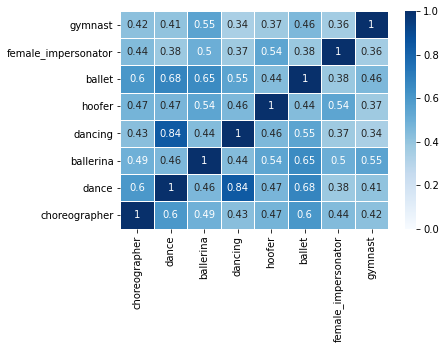

In [5]:
adj_matrix_in_coslice("dancer")

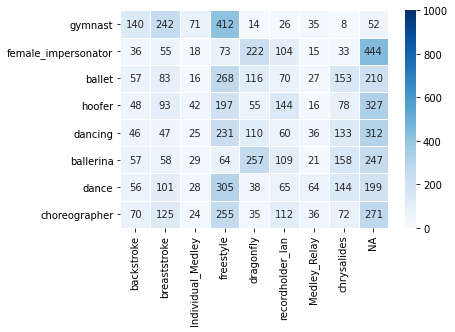

In [6]:
object_TINT_edge_correspondence_heatmap("butterfly","dancer")